### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 12th at 11.59pm CT
---

## Problem 1

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [130]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
import time

data = np.load('../../../homeworks/hw_data/hw8_data_1.npy')
print(data.dtype.names)
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']
z_shift = data['redshift']
specClass = data['specClass']

print('Number of QSOs: ', len(specClass[np.where(specClass == 'QSO')]))
print('Number of Galaxies: ',len(specClass[np.where(specClass == 'GALAXY')]))

('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
Number of QSOs:  7192
Number of Galaxies:  42808


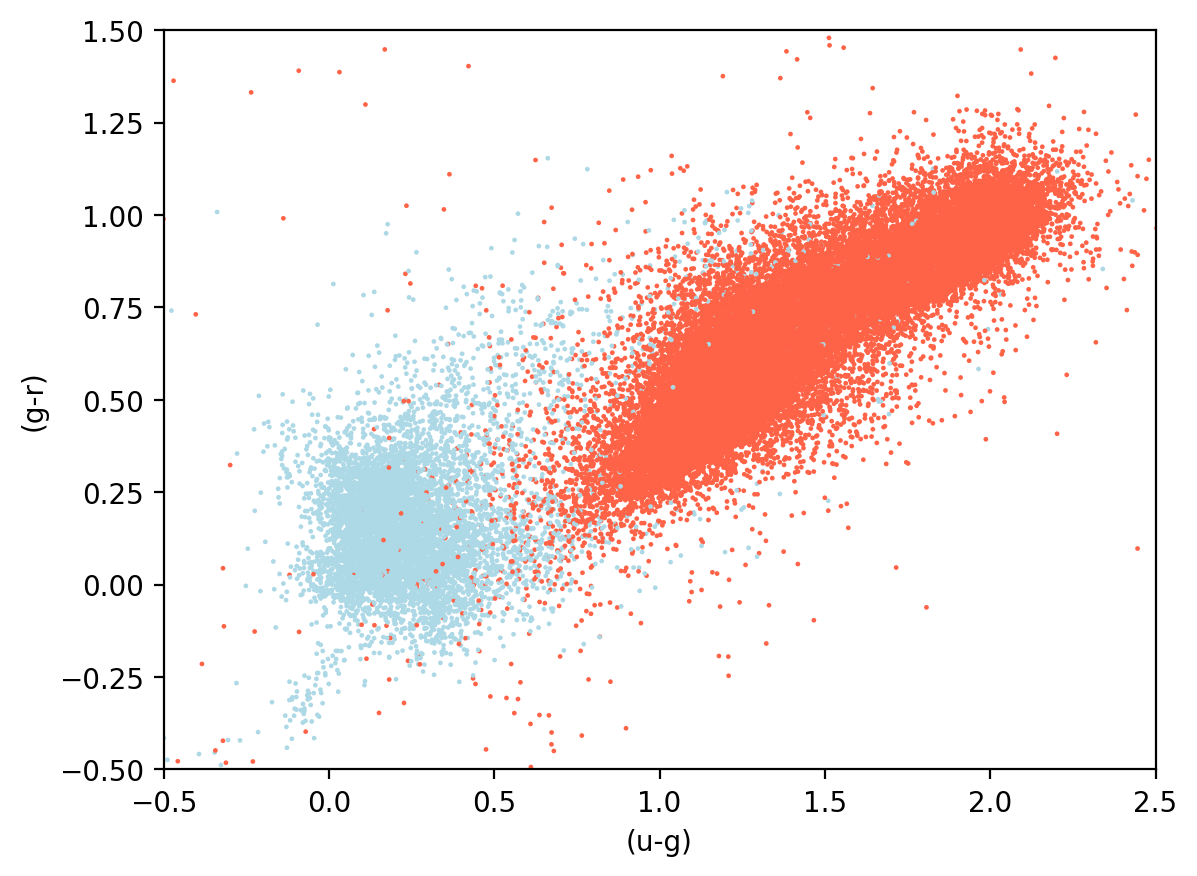

In [131]:
colors = ["lightblue" if spec == "QSO" else "tomato" for spec in specClass]
plt.scatter(u_g, g_r, c=colors, s=0.5)
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.xlabel('(u-g)')
plt.ylabel('(g-r)')
plt.show()

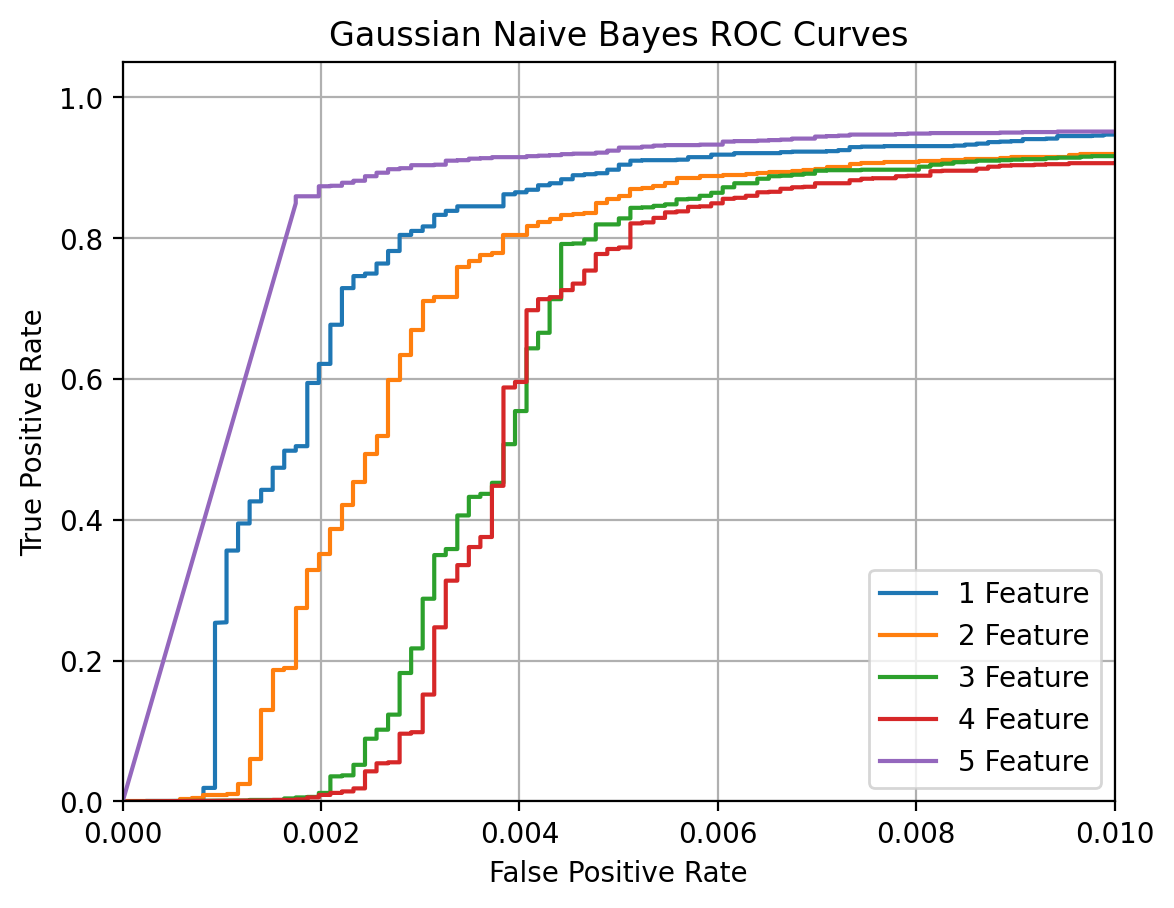

In [140]:
from  sklearn.model_selection import train_test_split

X = np.vstack([u_g, g_r, r_i, i_z, z_shift]).T
y = np.array([1 if spec == 'QSO' else 0 for spec in specClass])

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc

#----------------------------------------------------------------------
# perform Naive Bayes
for i in range(1, X.shape[1] + 1):
    # Select the first i features
    # X_train_i = X_train[:, :i]
    # X_test_i = X_test[:, :i]

    # MRS Initialize the classifier and train on the 
    clf = GaussianNB()
    clf.fit(X_train[:, :i], y_train)
 
    # MRS Pick out the QSOs from classifier class
    quasar_idx = np.where(clf.classes_ == 1)[0][0]
    probs = clf.predict_proba(X_test[:, :i])[:, quasar_idx]

    # Compute ROC curve 
    fpr, tpr, thresh = roc_curve(y_test, probs)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{i} Feature')

# Final plot tweaks
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Naive Bayes ROC Curves')
plt.xlim(0, 0.01)  # Zoomed in on FPR
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



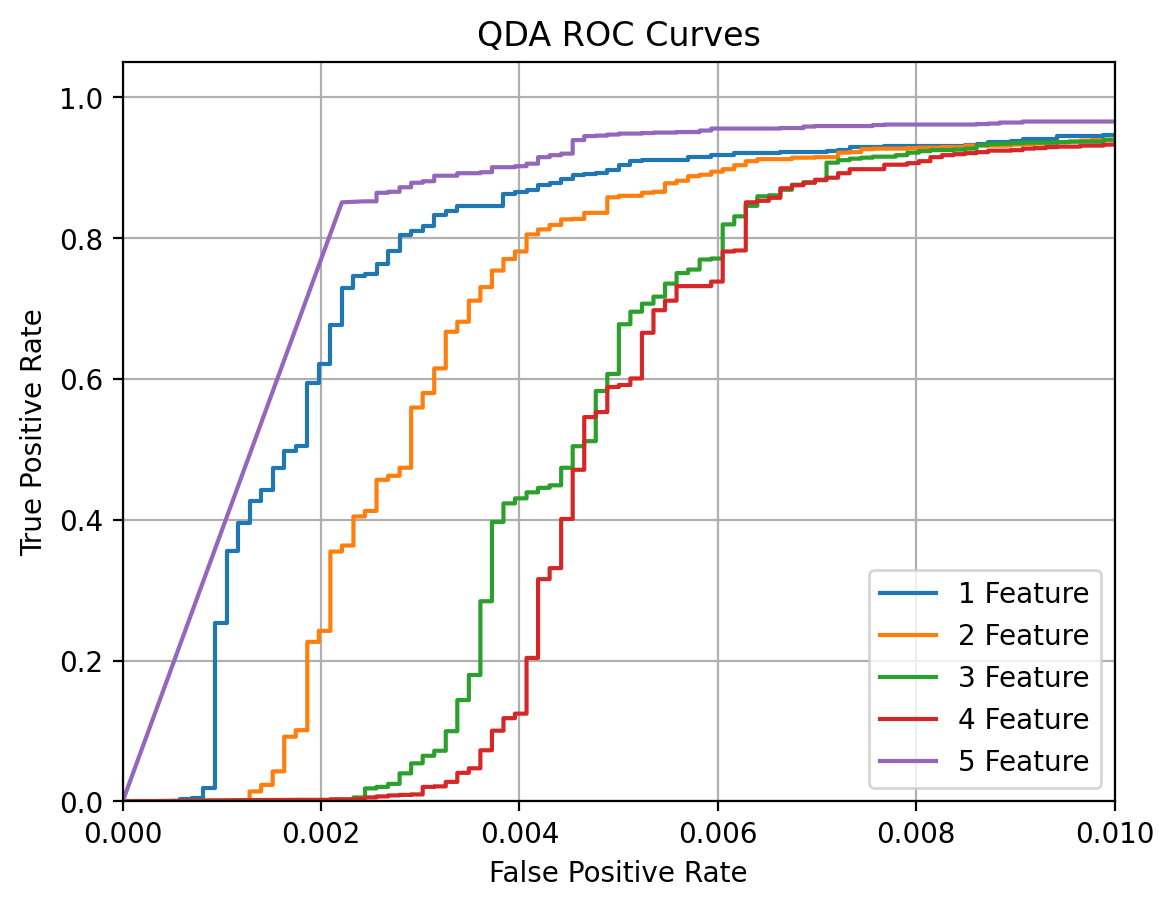

In [141]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
# perform Naive Bayes
for i in range(1, X.shape[1] + 1):
    # MRS Initialize the classifier and train on the 
    clf = QDA()
    clf.fit(X_train[:, :i], y_train)
 
    # MRS Pick out the QSOs from classifier class
    quasar_idx = np.where(clf.classes_ == 1)[0][0]
    probs = clf.predict_proba(X_test[:, :i])[:, quasar_idx]

    # Compute ROC curve 
    fpr, tpr, thresh = roc_curve(y_test, probs)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{i} Feature')

# Final plot tweaks
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('QDA ROC Curves')
plt.xlim(0, 0.01)  # Zoomed in on FPR
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

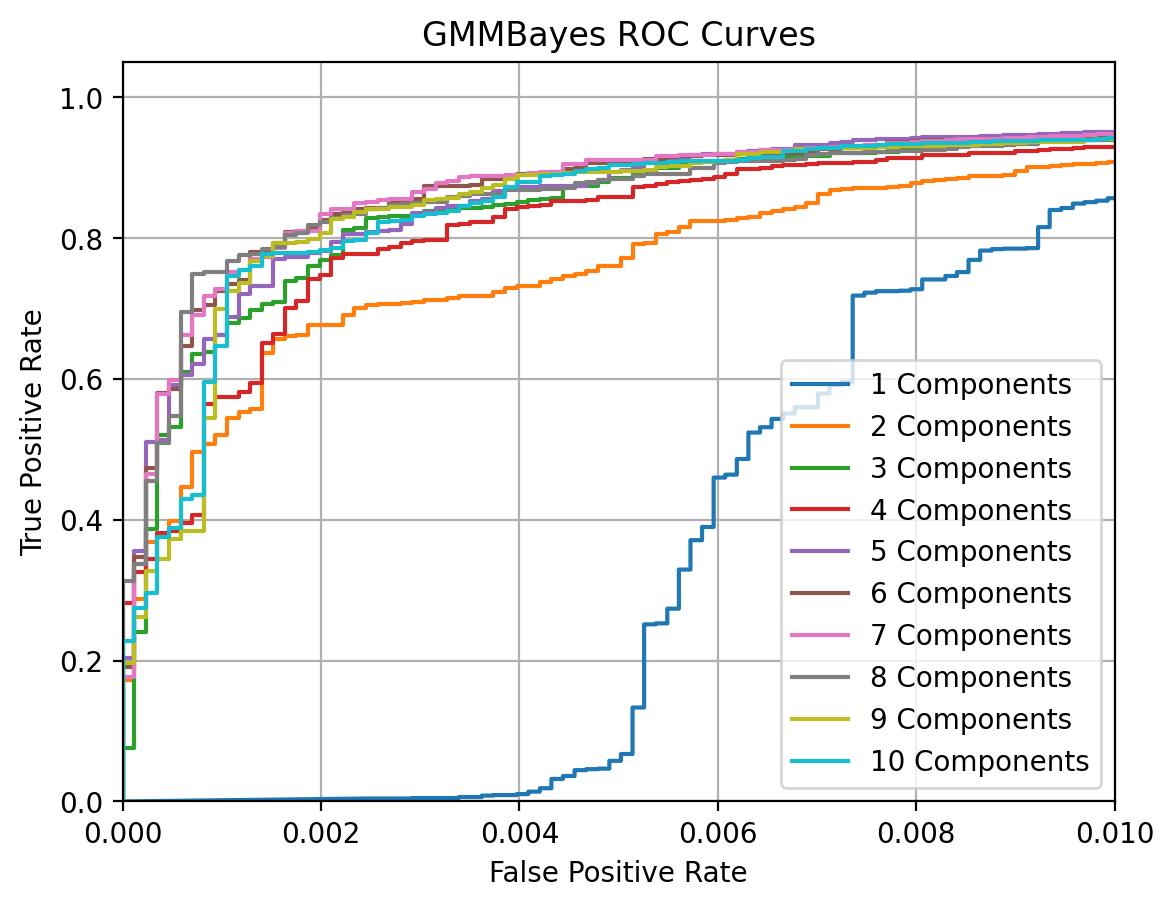

In [142]:
from astroML.classification import GMMBayes

X = np.vstack([u_g, g_r, r_i, i_z]).T
y = np.array([1 if spec == 'QSO' else 0 for spec in specClass])

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

for n_comps in range(1, 11):
    clf = GMMBayes(n_components=n_comps, covariance_type='full')
    clf.fit(X_train, y_train)
    # MRS Pick out the QSOs from classifier class
    quasar_idx = np.where(clf.classes_ == 1)[0][0]
    probs = clf.predict_proba(X_test)[:, quasar_idx]

    # Compute ROC curve 
    fpr, tpr, thresh = roc_curve(y_test, probs)

 # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{n_comps} Components')

# Final plot tweaks
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GMMBayes ROC Curves')
plt.xlim(0, 0.01)  # Zoomed in on FPR
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

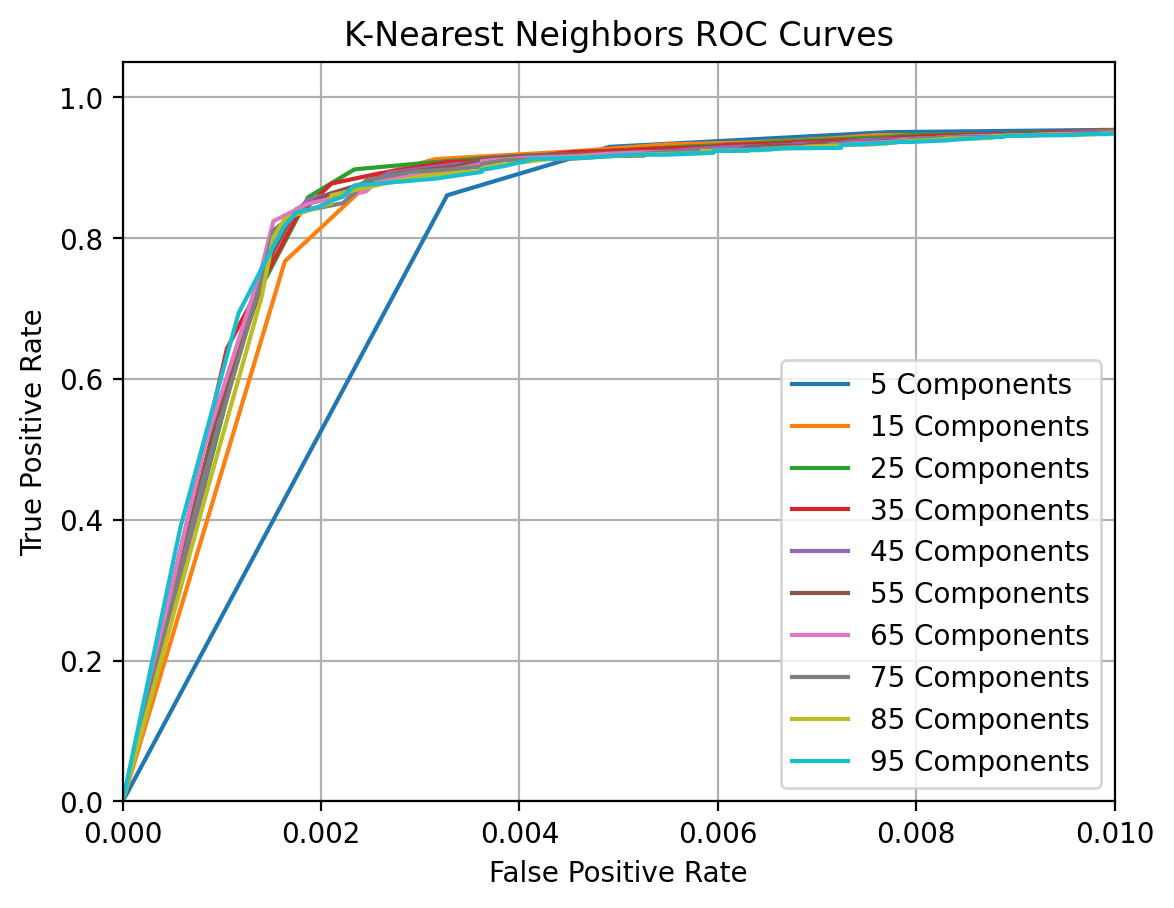

In [143]:
from sklearn.neighbors import KNeighborsClassifier

for n_nbors in range(5, 101, 10):
    clf = KNeighborsClassifier(n_neighbors=n_nbors)
    clf.fit(X_train, y_train)
    # MRS Pick out the QSOs from classifier class
    quasar_idx = np.where(clf.classes_ == 1)[0][0]
    probs = clf.predict_proba(X_test)[:, quasar_idx]

    # Compute ROC curve 
    fpr, tpr, thresh = roc_curve(y_test, probs)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{n_nbors} Components')

# Final plot tweaks
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Nearest Neighbors ROC Curves')
plt.xlim(0, 0.01)  # Zoomed in on FPR
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

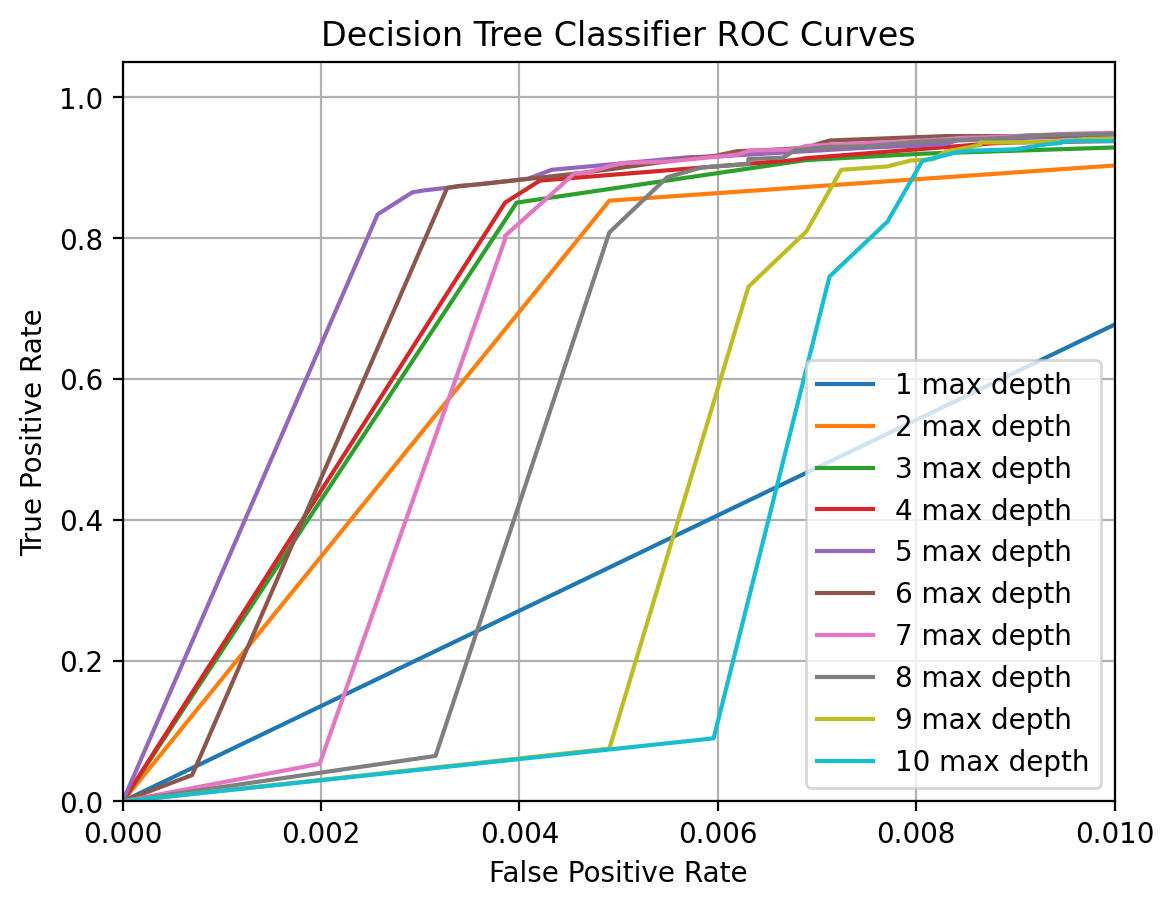

In [145]:
from sklearn.tree import DecisionTreeClassifier



for n_tree in range(1, 11):
    clf = DecisionTreeClassifier(max_depth=n_tree, criterion='entropy')
    clf.fit(X_train, y_train)
    # MRS Pick out the QSOs from classifier class
    quasar_idx = np.where(clf.classes_ == 1)[0][0]
    probs = clf.predict_proba(X_test)[:, quasar_idx]

    # Compute ROC curve 
    fpr, tpr, thresh = roc_curve(y_test, probs)


    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{n_tree} max depth')

# Final plot tweaks
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Classifier ROC Curves')
plt.xlim(0, 0.01)  # Zoomed in on FPR
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Problem 2

The first few steps of this problem are the same as the previous problem.


1. Read in the same galaxy color data used above. Slice the data array to only take every other 10th row. From this reduced data volume, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. 


2. We're going to make classification pretty tough for our deep neural network. Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class. Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$. The plot should include appropriate axis labels and a legend.


3. Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing. Set the `random_state` in your train-test split to be `42` for reproducibility (and easy comparison with my solutions).


4. Scale your training and testing data to prepare it for the DNN. 


5. Train scikit-learn's multi-layer perceptron classifier with ReLU activation, stochastic gradient descent, two hidden layers of respective sizes of $5$ and $2$, and using `max_iter=1000`, and `random_state=42`. As with classifiers in last week's homework, plot an ROC curve that shows the network's performance on the scaled testing data. 


6. Now let's optimize the hyperparameters of your network. You will use `GridSearchCV` with the following hyperparameters for the network:

```
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
```

Remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.


7. Fit a new DNN using the best hyperparameters obtained in (6), and make a plot that has ROC curves for this new network and your original network. Let the x and y axes have the full limit range of 0 to 1. Voila!

In [147]:


data = np.load('../../../homeworks/hw_data/hw8_data_1.npy')
data = data[::10]
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']
z_shift = data['redshift']
specClass = data['specClass']

print('Number of QSOs: ', len(specClass[np.where(specClass == 'QSO')]))
print('Number of Galaxies: ',len(specClass[np.where(specClass == 'GALAXY')]))

Number of QSOs:  736
Number of Galaxies:  4264


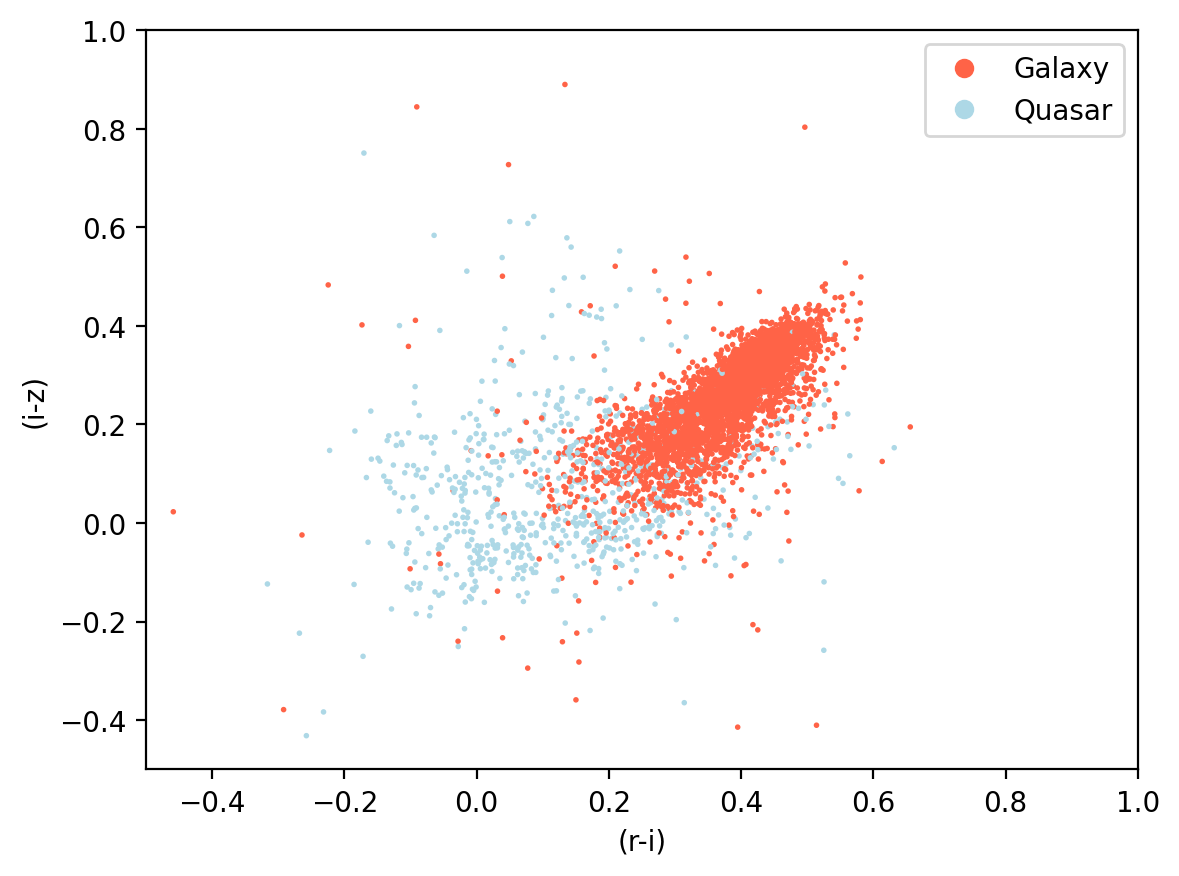

In [148]:
colors = ["lightblue" if spec == "QSO" else "tomato" for spec in specClass]
plt.scatter(r_i, i_z, c=colors, s=1)
plt.plot(np.nan, np.nan, 'o', color='tomato', label='Galaxy')
plt.plot(np.nan, np.nan, 'o', color='lightblue', label='Quasar')

plt.xlim(-0.5, 1.0)
plt.ylim(-0.5, 1.0)
plt.xlabel('(r-i)')
plt.ylabel('(i-z)')
plt.legend()
plt.show()

In [149]:
X = np.vstack([r_i, i_z]).T
y = np.array([1 if spec == 'QSO' else 0 for spec in specClass])

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2,random_state=42 )


from sklearn.preprocessing import StandardScaler
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

print(X_train_scaled)

[[-0.03811473 -0.41028064]
 [-0.02883028 -0.26656157]
 [ 0.26822235 -0.05539333]
 ...
 [ 0.4468233   0.31785884]
 [-0.13340518 -0.10778888]
 [-0.26837918 -0.25543135]]


/var/folders/ls/sw9901md6hg56d8jmwp77nyr0000gp/T/ipykernel_8823/1066773252.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


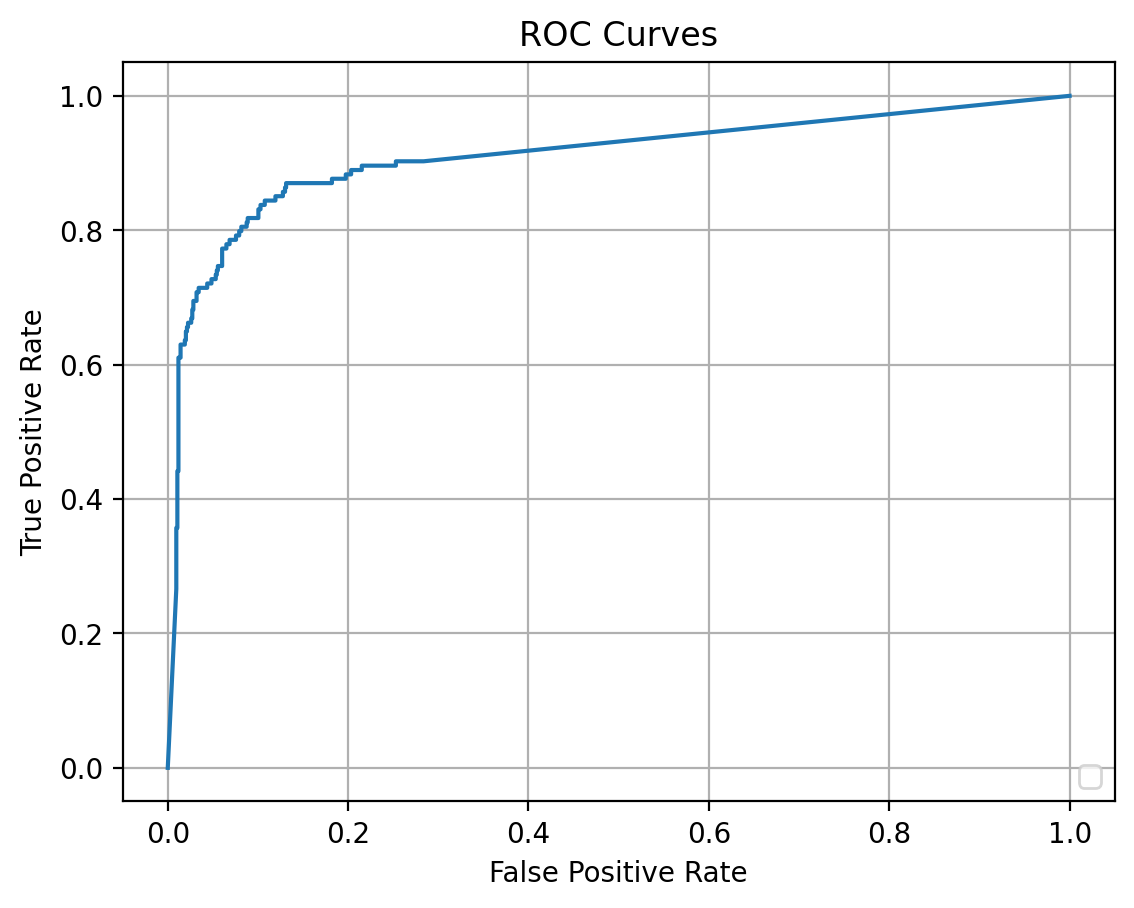

In [158]:
from sklearn.neural_network import MLPClassifier

clf= MLPClassifier(activation='relu', solver='sgd',hidden_layer_sizes=[5,2], max_iter=1000, random_state=42)

clf.fit(X_train_scaled, y_train)

probs = clf.predict_proba(X_test_scaled)

# Compute ROC curve 
fpr, tpr, thresh= roc_curve(y_test, probs[:, 1])


# Plot the ROC curve
plt.plot(fpr, tpr)

# Final plot tweaks
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
#plt.xlim(0, 0.01)  # Zoomed in on FPR
#plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [152]:

from sklearn.model_selection import GridSearchCV
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
grid_search = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)
# MRS Print out the best parameters and best score for MLPClassifier
print(grid_search.best_params_)
print(grid_search.best_score_)

/Users/smitm77/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/smitm77/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/smitm77/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: C

{'activation': 'tanh', 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 1000, 'random_state': 42, 'solver': 'lbfgs'}
0.9359999999999999


/Users/smitm77/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


/Users/smitm77/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/var/folders/ls/sw9901md6hg56d8jmwp77nyr0000gp/T/ipykernel_8823/400707746.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


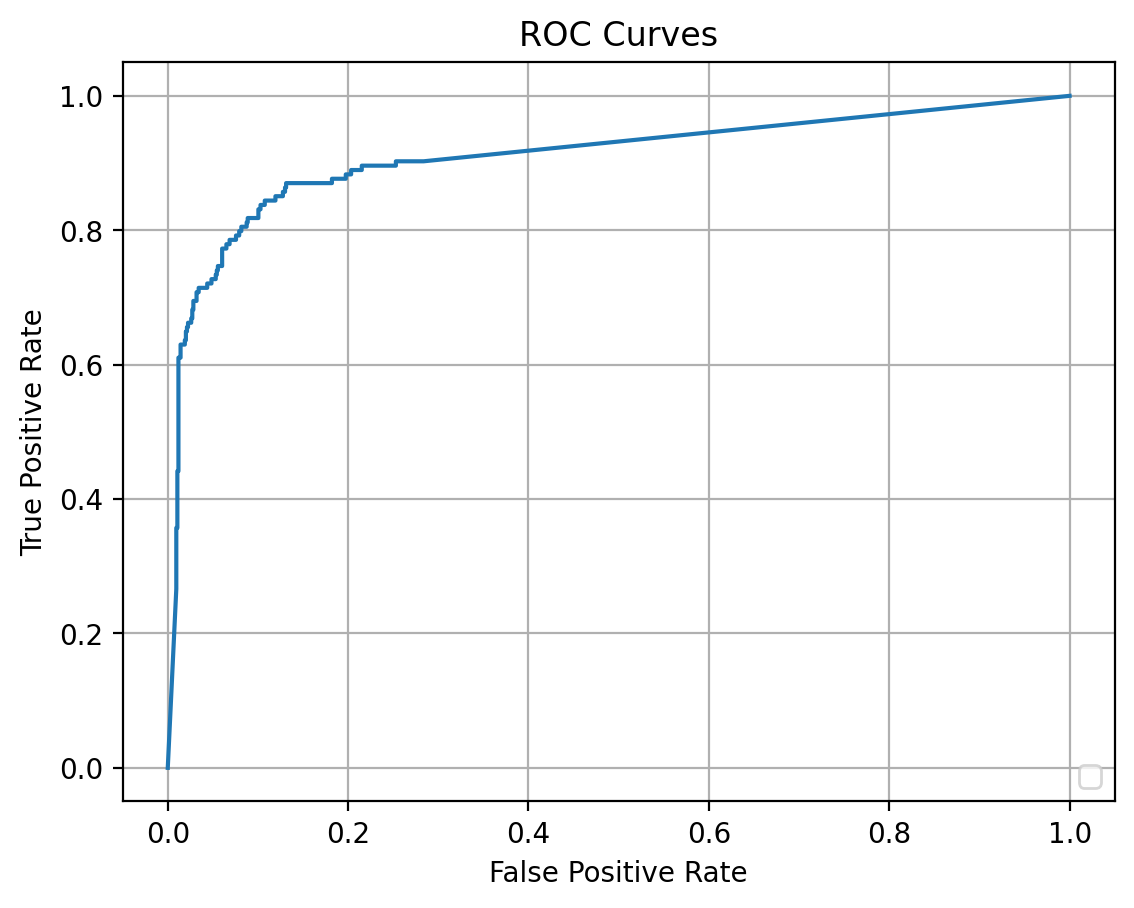

In [157]:
# MRS saw that best_estimator_ also prints out the best ridge model to use (So you could use either method I just thought best_estimator_ was a neat little attribute)
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

probs = clf.predict_proba(X_test_scaled)

# Compute ROC curve 
fpr, tpr, thresh= roc_curve(y_test, probs[:, 1])
# Plot the ROC curve
plt.plot(fpr, tpr)

# Final plot tweaks
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
#plt.xlim(0, 0.01)  # Zoomed in on FPR
#plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()